In [144]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from random import seed,sample
import datetime as dt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler # Undersampling for Unbalanced Data
from imblearn.over_sampling import SMOTE # Oversampling for Unbalanced Data
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Data Encoders
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
import networkx as nx

In [145]:
df = pd.read_csv("C:/Users/sieji/OneDrive/Documents/NUS/BT4012/bt4012/fraudTrain.csv")
df = pd.concat([df[df["is_fraud"]==0].sample(frac=0.20, random_state=42), df[df["is_fraud"] == 1]])

In [146]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
811778,811778,2019-12-07 10:55:06,676173792455,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,Brittany,Cox,F,07177 William Dale Apt. 547,...,34.0287,-118.4924,92043,"Civil engineer, contracting",1961-04-25,f32d1f4b2a918f4c2f6acdc83033ee35,1354877706,33.287851,-118.740970,0
1101718,1101718,2020-04-03 13:10:06,30518206766474,fraud_Lind-Buckridge,entertainment,85.81,Tamara,Martinez,F,471 Marquez Prairie Suite 680,...,36.7154,-89.6287,1019,Aeronautical engineer,1979-01-26,f5dad8e2d7c39d81502d846a20286659,1364994606,36.539950,-89.857416,0
800013,800013,2019-12-04 07:07:04,4658490815480264,fraud_Hackett-Lueilwitz,grocery_pos,99.30,Tara,Richards,F,4879 Cristina Station,...,39.9636,-79.7853,184,Systems developer,1945-11-04,1d023bc78ab93ab65a35bbb53bcc67bd,1354604824,39.582872,-78.838550,0
398945,398945,2019-06-30 18:43:08,4716561796955522,fraud_Lynch-Wisozk,home,42.09,Lauren,Anderson,F,11014 Chad Lake Apt. 573,...,48.2777,-112.8456,743,Water engineer,1972-05-04,dbf6c06d3277438afdf7af883fb4285f,1341081788,48.310513,-112.837535,0
207455,207455,2019-04-15 19:57:49,3528407217576457,fraud_Fisher-Schowalter,shopping_net,4.24,Patricia,Leach,F,71309 Martinez Stravenue,...,36.4715,-82.4834,87124,Warden/ranger,1987-02-14,88814660aba0101b174e1e8137f4a7af,1334519869,37.329094,-82.070746,0


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 265340 entries, 811778 to 1295733
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             265340 non-null  int64  
 1   trans_date_trans_time  265340 non-null  object 
 2   cc_num                 265340 non-null  int64  
 3   merchant               265340 non-null  object 
 4   category               265340 non-null  object 
 5   amt                    265340 non-null  float64
 6   first                  265340 non-null  object 
 7   last                   265340 non-null  object 
 8   gender                 265340 non-null  object 
 9   street                 265340 non-null  object 
 10  city                   265340 non-null  object 
 11  state                  265340 non-null  object 
 12  zip                    265340 non-null  int64  
 13  lat                    265340 non-null  float64
 14  long                   265340 non-n

In [148]:
total_rows = len(df)

fraud_count = df[df["is_fraud"] == 1]["is_fraud"].count()
non_fraud_count = df[df["is_fraud"] == 0]["is_fraud"].count()

fraud_proportion = fraud_count / total_rows
non_fraud_proportion = non_fraud_count / total_rows

print("Proportion of Fraudulent Transactions:", fraud_proportion)
print("Proportion of Non-Fraudulent Transactions:", non_fraud_proportion)


Proportion of Fraudulent Transactions: 0.028288233963970753
Proportion of Non-Fraudulent Transactions: 0.9717117660360293


In [149]:

#dual classification graph creation function
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    
    # Create graph nodes by mapping unique credit card numbers and merchant IDs
    mapping = {x:node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    
    #Group by 'from', 'to', 'amt', 'is_fraud' columns and calculate sum
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
    
    #Convert 'is_fraud' column to 0 and 1
    df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x>0 else 0)
    
    #Graph creation
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)
    
    #Node property settings
    nx.set_node_attributes(G,{x:1 for x in df["from"].unique()}, "bipartite")
    nx.set_node_attributes(G,{x:2 for x in df["to"].unique()}, "bipartite")
    
    #Edge label settings
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, 
                       "label")

    #Edge weight settings
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from","to","amt"]].iterrows()}, 
                       "weight")
    return G

#Triple classification graph creation function
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["cc_num"].values.tolist() + 
                                                        df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])

    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    return G

Build the Bipartite and Tripartite graphs

In [150]:
G_bu = build_graph_bipartite(df, nx.Graph(name = 'Bipartite Undirected'))
G_bd = build_graph_bipartite(df, nx.DiGraph(name = 'Bipartite Directed'))
G_tu = build_graph_tripartite(df, nx.Graph(name = 'Bipartite Undirected'))
G_td = build_graph_tripartite(df, nx.DiGraph(name='Tripartite Directed'))

In [151]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_bu)

True

In [152]:

def print_graph_info(graph):
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)
    graph_density = num_edges / (num_nodes * (num_nodes - 1) / 2)  # If the graph is undirected
    average_degree = sum(dict(graph.degree()).values()) / num_nodes

    print("Number of nodes:", num_nodes)
    print("Number of edges:", num_edges)
    print("Graph density:", graph_density)
    print("Average degree:", average_degree)
    print("Number of nodes:", num_nodes)
    
print_graph_info(G_bu)


Number of nodes: 1676
Number of edges: 201725
Graph density: 0.1437146012182524
Average degree: 240.7219570405728
Number of nodes: 1676


In [153]:
print_graph_info(G_tu)

Number of nodes: 267016
Number of edges: 530680
Graph density: 1.4886402974790514e-05
Average degree: 3.974892890313689
Number of nodes: 267016


Plotting distribution of node degrees for both graph structures

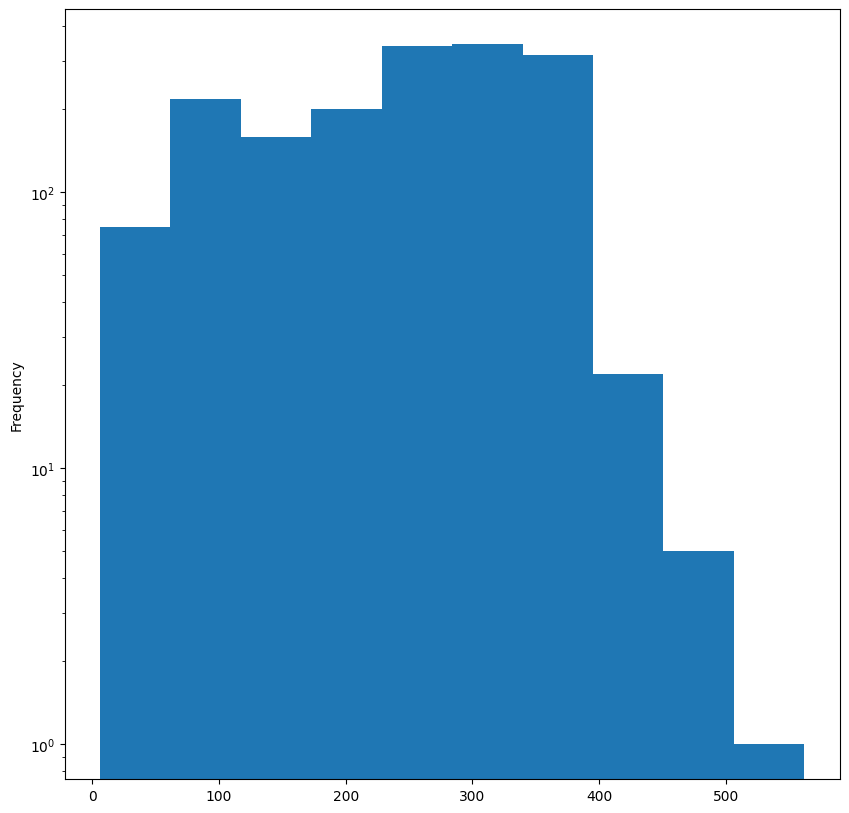

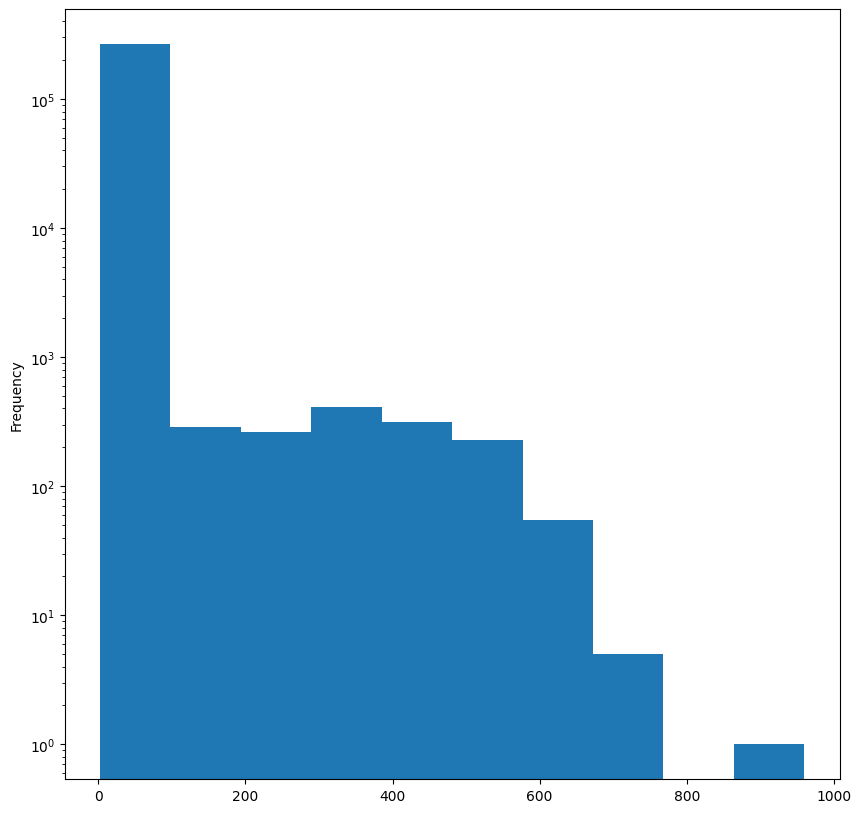

In [154]:
for G in [G_bu, G_tu]:
    plt.figure(figsize=(10,10))
    degrees = pd.Series(
        {
            k:v for k,v in nx.degree(G)
        }
    )
    degrees.plot.hist()
    plt.yscale("log")

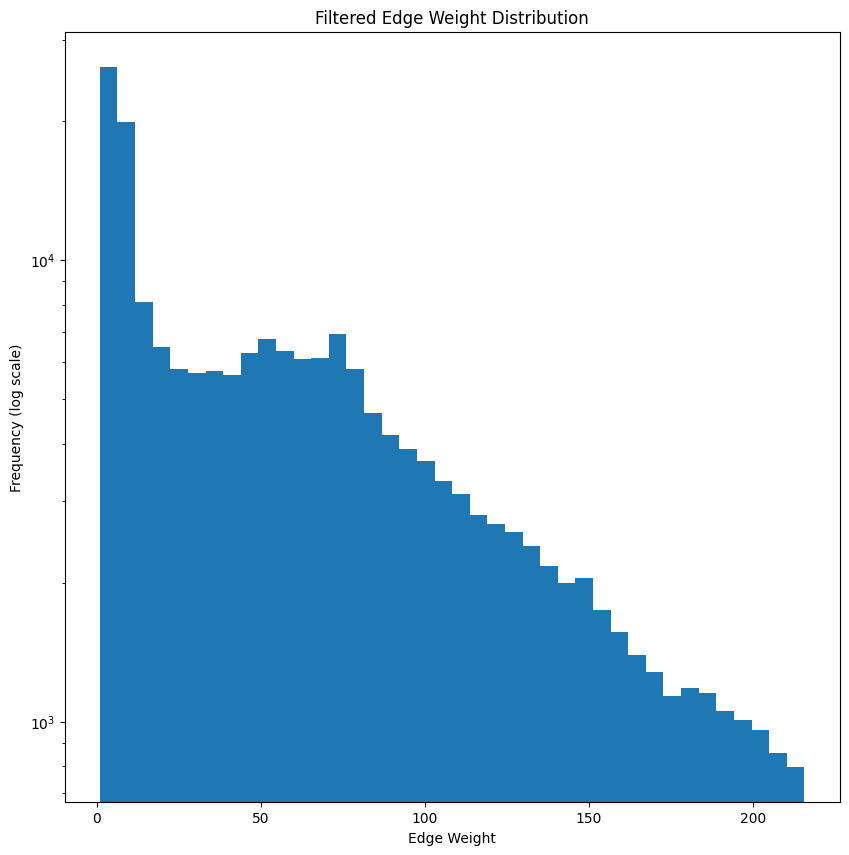

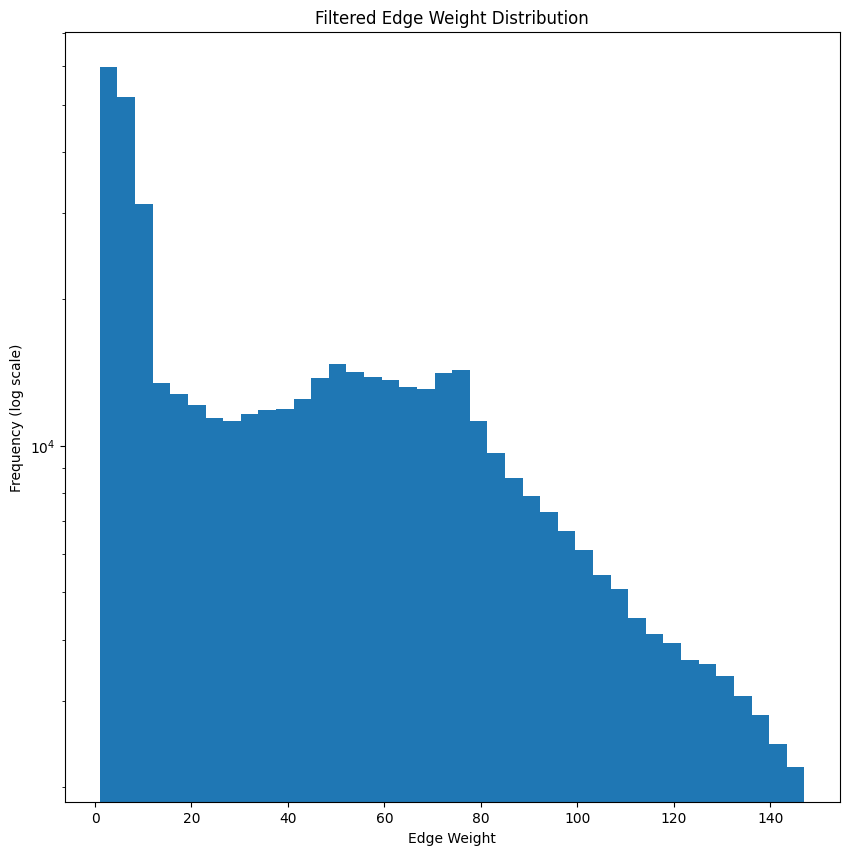

In [155]:
graph_list = [G_bu, G_tu]

for G in graph_list:
    all_edge_weights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
    
    quantiles = np.quantile(all_edge_weights.values, [0.10, 0.50, 0.70, 0.9, 1.0])
    
    quant_dist = np.quantile(all_edge_weights.values, [0.10, 0.50, 0.70, 0.9])
    
    all_edge_weights_filtered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) if d[2]["weight"] < quant_dist[-1]})
    
    plt.figure(figsize=(10, 10))
    all_edge_weights_filtered.plot.hist(bins=40)
    plt.yscale("log")
    plt.xlabel('Edge Weight')
    plt.ylabel('Frequency (log scale)')
    plt.title('Filtered Edge Weight Distribution')
    plt.show()


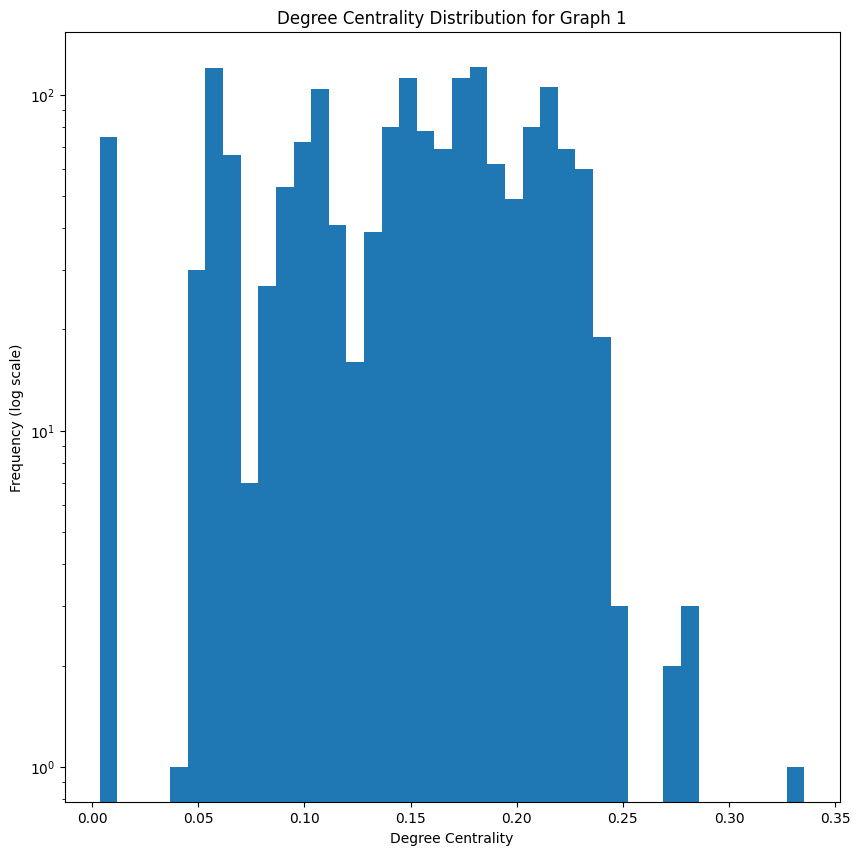

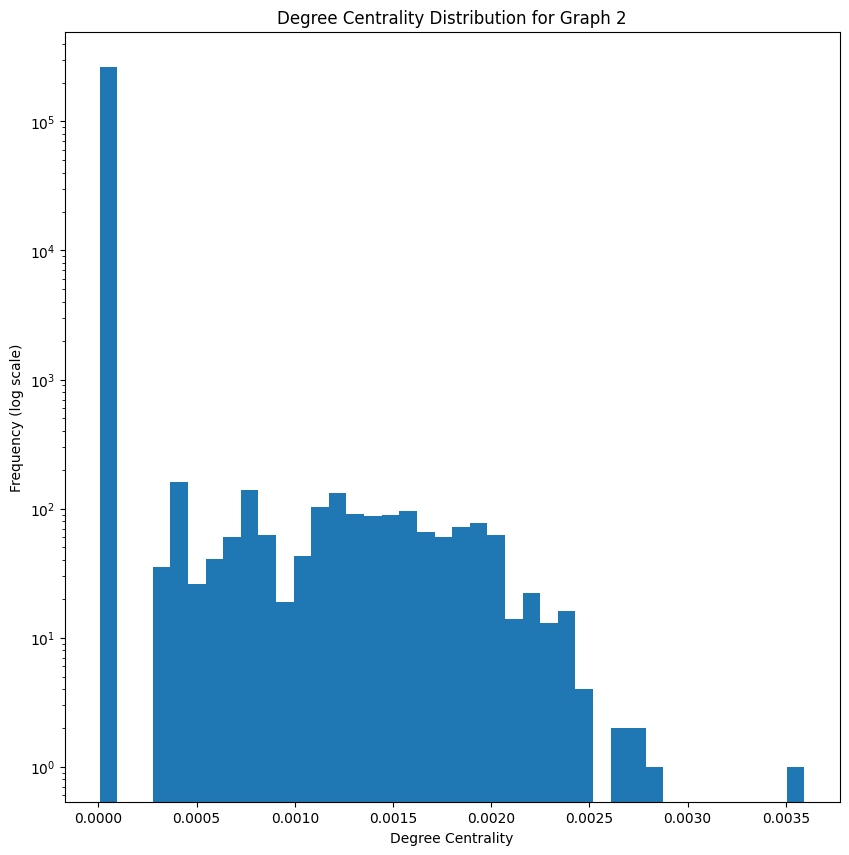

In [156]:
graph_list = [G_bu, G_tu]

degree_centrality_results = {}

for i, G in enumerate(graph_list):
    degree_centrality = nx.degree_centrality(G)
    
    degree_centrality_series = pd.Series(degree_centrality)
    
    plt.figure(figsize=(10, 10))
    degree_centrality_series.plot.hist(bins=40)
    plt.yscale("log")
    plt.xlabel('Degree Centrality')
    plt.ylabel('Frequency (log scale)')
    plt.title(f'Degree Centrality Distribution for Graph {i + 1}')
    plt.show()

In [157]:
import community
parts = community.best_partition(G_bu, random_state=42, weight='weight')
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False)

11    542
2     175
0     160
10    145
7     109
8     102
4      90
12     82
3      78
6      73
5      48
9      41
1      31
Name: count, dtype: int64

The results indicate that the network can be partitioned into 18 distinct communities. These communities vary in size, with the largest community having 170 nodes and the smallest having 21 nodes. The varying sizes suggest that some groups of nodes are more tightly connected or influential than others within the network

<Axes: ylabel='Frequency'>

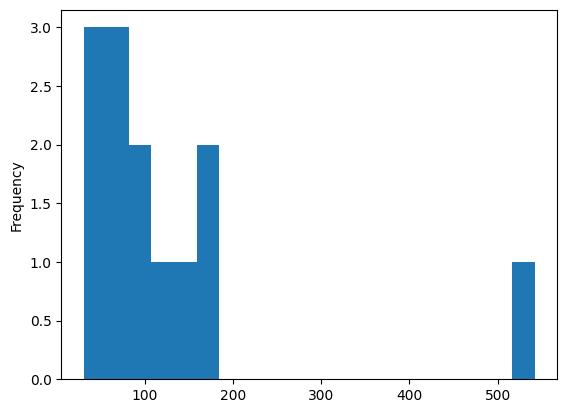

In [158]:
communities.value_counts().plot.hist(bins=20)

In [159]:
community_ratios = {}

for community_id in communities.unique():
    subgraph = nx.subgraph(G_bu, communities[communities == community_id].index)
    total_edges = subgraph.number_of_edges()
    fraud_edges = sum(nx.get_edge_attributes(subgraph, "label").values())

    ratio = 0 if total_edges == 0 else (fraud_edges / total_edges) * 100
    community_ratios[community_id] = ratio
pd.Series(community_ratios).sort_values(ascending=False)


1     35.365854
9     26.016260
10    19.354839
8     17.057903
6     15.853659
5     15.086207
4     13.765823
0     13.324538
2      9.314858
7      8.545270
3      8.037383
12     7.890499
11     1.532504
dtype: float64

The above is the fraudulent percentage provided at the community level. We can further plot the node-induced subgraphs for a particular community. In the code below, gId indicates the Community ID.

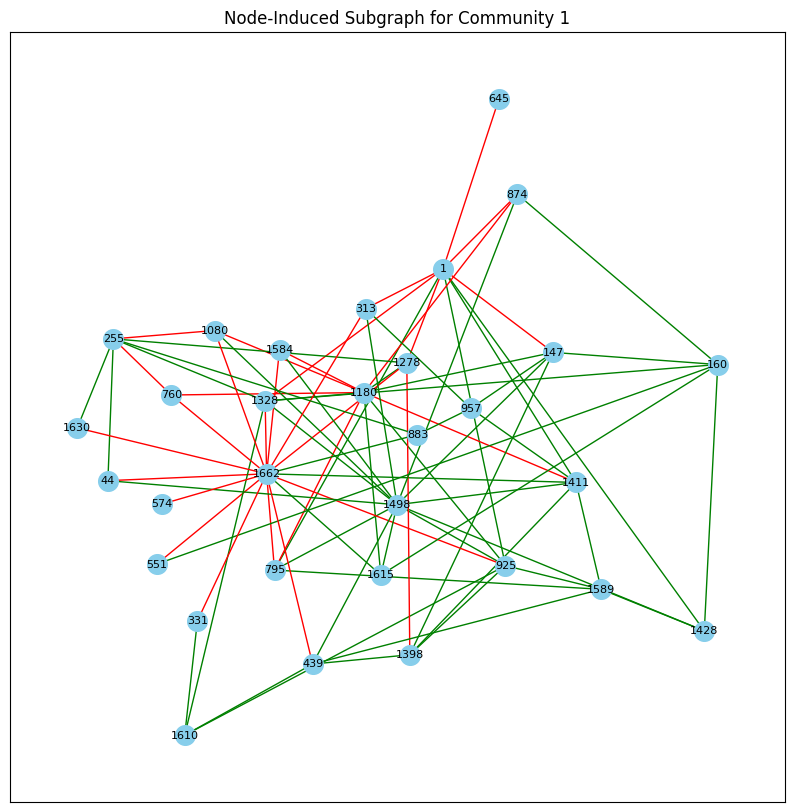

In [160]:
def plot_community_subgraph(graph, community_id):
    subgraph = nx.subgraph(graph, communities[communities == community_id].index)
    
    edge_colors = ["green" if subgraph.edges[edge]["label"] == 0 else "red" for edge in subgraph.edges()]

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(subgraph, seed=42)  # You can use different layout algorithms

    nx.draw_networkx_nodes(subgraph, pos, node_size=200, node_color="skyblue")
    nx.draw_networkx_labels(subgraph, pos, font_size=8)

    nx.draw_networkx_edges(subgraph, pos, width=1, edge_color=edge_colors)

    plt.title(f"Node-Induced Subgraph for Community {community_id}")
    plt.show()

plot_community_subgraph(G_bu, community_id=1)

Even though community 1 had the highest percentage of fraud transactions, it seems the volume density is little. Let us plot the community with the second highest percentage.

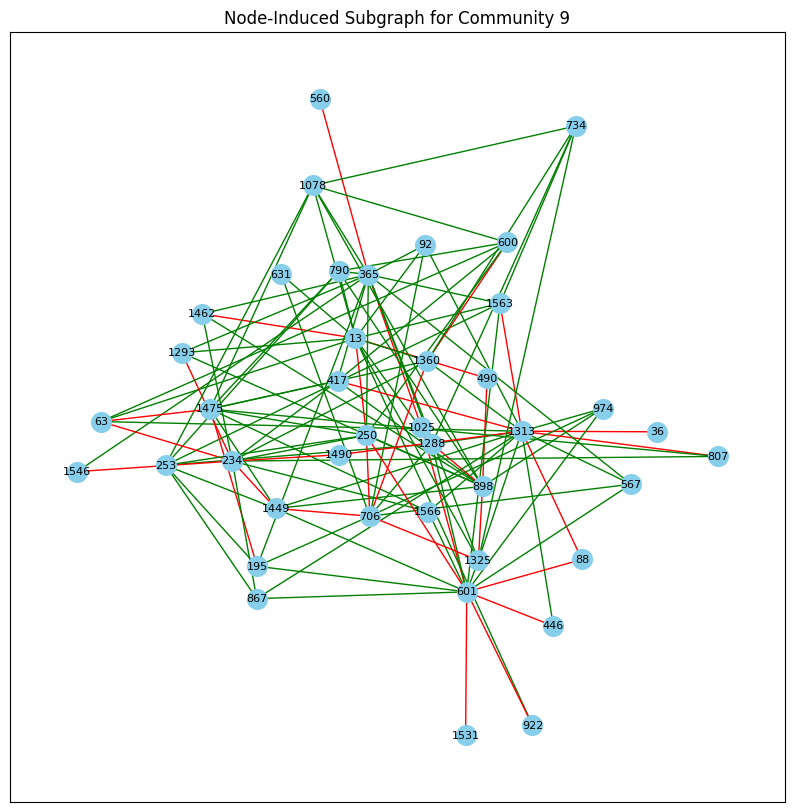

In [161]:
plot_community_subgraph(G_bu, community_id=9)


Community 9 seems more dense

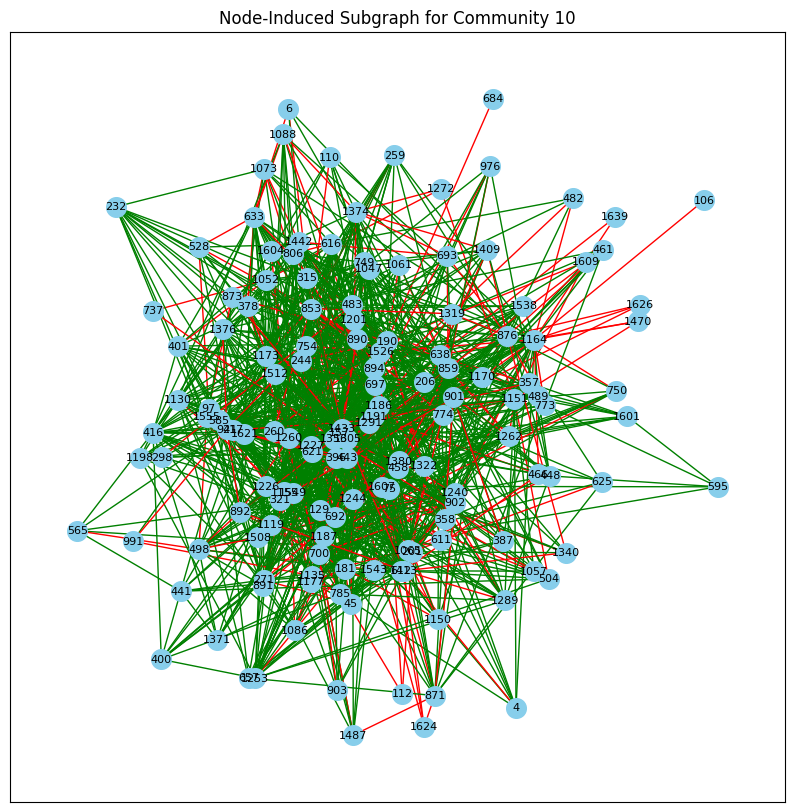

In [162]:
plot_community_subgraph(G_bu, community_id=10)

Community 10 contains the densest graph with many intersecting edges and nodes.

Now, we will plot for the community with the least fraud percentage

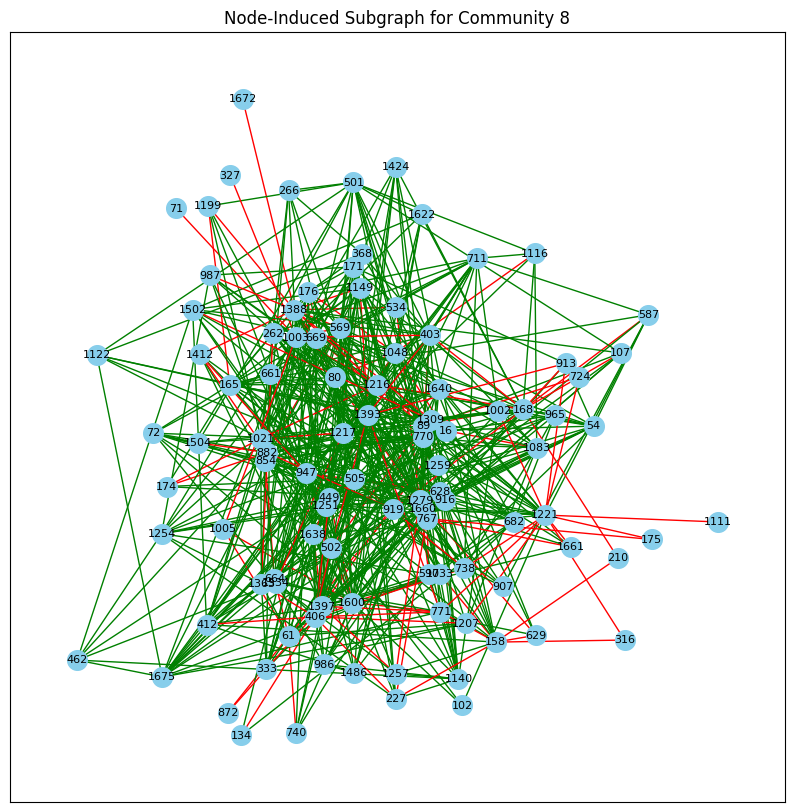

In [163]:
plot_community_subgraph(G_bu, community_id=8)

Handling Class Imbalance:
In order to build a random forest model, which can be computationally intensive, we will create a downsampled df with equal instances of both fraud and non-fraud classes. This saves time and resources when building the model.

In [204]:
from sklearn.utils import resample

df_majority = df[df.is_fraud == 0]
df_minority = df[df.is_fraud == 1]

num_samples = len(df_minority)

df_maj_downsampled = resample(df_majority, n_samples=num_samples, random_state=42)

df_downsampled = pd.concat([df_minority, df_maj_downsampled])

print(df_downsampled.is_fraud.value_counts())

G_down = build_graph_bipartite(df_downsampled)

is_fraud
1    7506
0    7506
Name: count, dtype: int64


Performing Train Test Split

In [205]:
from sklearn.model_selection import train_test_split

train_edges, temp_edges, train_labels, temp_labels = train_test_split(list(range(len(G_down.edges))),
                                                                      list(nx.get_edge_attributes(G_down, "label").values()),
                                                                      test_size = 0.20,
                                                                      random_state=42)

val_edges, test_edges, val_labels, test_labels = train_test_split(temp_edges, temp_labels, test_size=0.5, random_state=42)

In [206]:
edgs = list(G_down.edges)

train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()

train_graph.add_nodes_from(set(G_down.nodes) - set(train_graph.nodes))


In [207]:
from node2vec import Node2Vec

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


In [170]:
from sklearn.ensemble import RandomForestClassifier
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder
from sklearn import metrics

embedding_classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
results = []
for embedding_class in embedding_classes:
    embeddings_train = embedding_class(keyed_vectors=model_train.wv)
    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    val_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in val_edges]
    
    rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf_classifier.fit(train_embeddings, train_labels)

    y_pred = rf_classifier.predict(val_embeddings)
    precision = metrics.precision_score(val_labels, y_pred)
    recall = metrics.recall_score(val_labels, y_pred)
    f1 = metrics.f1_score(val_labels, y_pred)
    auc = metrics.roc_auc_score(val_labels, y_pred)

    results.append({
        'Embedding_Class': embedding_class.__name__,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    })

results_df = pd.DataFrame(results)
print(results_df)

      Embedding_Class  Precision    Recall  F1-Score       AUC
0    HadamardEmbedder   0.704918  0.057641  0.106568  0.516251
1     AverageEmbedder   0.717537  0.718499  0.718017  0.711903
2  WeightedL1Embedder   0.714286  0.026810  0.051680  0.507818
3  WeightedL2Embedder   0.714286  0.026810  0.051680  0.507818


It seems the Average Embedding method gives  the best evaluation metric scores with 70.1% AUC. We will now improve the perfomance metrics by doing hyperparamater tuning

Testing on validation set

In [172]:
y_pred_binary = (y_pred_prob > 0.5).astype(int)

import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score,average_precision_score

precision = precision_score(val_labels, y_pred_binary)
recall = recall_score(val_labels, y_pred_binary)
pr_auc = average_precision_score(val_labels, y_pred_prob)
roc_auc = roc_auc_score(val_labels, y_pred_prob)
f1 = f1_score(val_labels, y_pred_binary)

metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'PR AUC', 'ROC AUC'],
    'Score': [precision, recall, f1, pr_auc, roc_auc]
})

print(metrics_df)


      Metric     Score
0  Precision  0.717599
1     Recall  0.705094
2   F1 Score  0.711291
3     PR AUC  0.732505
4    ROC AUC  0.754391


Testing on test set

Saving results in separate DF to be displayed at the end for comparison.

In [192]:
if 'final_results' not in locals():
    final_results = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1 Score', 'PR AUC', 'ROC AUC'])

model_name = 'Random Forest'  # Update with the relevant model name

new_row = {'Model': model_name, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'PR AUC': pr_auc, 'ROC AUC': roc_auc}
final_results = pd.concat([final_results, pd.DataFrame([new_row])], ignore_index=True)


Building XGBoost model now

In [209]:
# Create training and testing embeddings
train_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
val_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in val_edges]
test_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
train_embeddings_np = np.array(train_embeddings)
val_embeddings_np = np.array(val_embeddings)
test_embeddings = np.array(test_embeddings)
test_embeddings_np = np.array(test_embeddings)

train_labels_np = np.array(train_labels)
val_labels_np = np.array(val_labels)
test_labels_np = np.array(test_labels)

In [194]:
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    eval_metric='logloss'
)

xgb_classifier.fit(train_embeddings_np, train_labels_np)

y_pred_prob_xgb = xgb_classifier.predict_proba(val_embeddings_np)[:, 1]

y_pred_binary_xgb = (y_pred_prob_xgb > 0.5).astype(int)

precision_xgb = precision_score(val_labels_np, y_pred_binary_xgb)
recall_xgb = recall_score(val_labels_np, y_pred_binary_xgb)
f1_xgb = f1_score(val_labels_np, y_pred_binary_xgb)
pr_auc_xgb = average_precision_score(val_labels_np, y_pred_prob_xgb)
roc_auc_xgb = roc_auc_score(val_labels_np, y_pred_prob_xgb)
model_name = 'XGBoost'

new_row2 = {'Model': model_name, 'Precision': precision_xgb, 'Recall': recall_xgb, 'F1 Score': f1_xgb, 'PR AUC': pr_auc_xgb, 'ROC AUC': roc_auc_xgb}


In [195]:
final_results = pd.concat([final_results, pd.DataFrame([new_row2])], ignore_index=True)
final_results

,Model,Precision,Recall,F1 Score,PR AUC,ROC AUC
0,Random Forest,0.690083,0.662698,0.676113,0.730792,0.734475
1,XGBoost,0.708459,0.628686,0.666193,0.717174,0.731947


Building Catboost Model now

In [197]:
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_seed=42)

catboost_classifier.fit(train_embeddings_np, train_labels_np, eval_set=(val_embeddings_np, val_labels_np))

y_pred_prob = catboost_classifier.predict_proba(val_embeddings_np)[:, 1]

0:	learn: 0.6863037	test: 0.6880551	best: 0.6880551 (0)	total: 223ms	remaining: 22.1s
1:	learn: 0.6806522	test: 0.6845554	best: 0.6845554 (1)	total: 263ms	remaining: 12.9s
2:	learn: 0.6752792	test: 0.6804198	best: 0.6804198 (2)	total: 301ms	remaining: 9.74s
3:	learn: 0.6712672	test: 0.6771892	best: 0.6771892 (3)	total: 342ms	remaining: 8.2s
4:	learn: 0.6668267	test: 0.6733986	best: 0.6733986 (4)	total: 384ms	remaining: 7.29s
5:	learn: 0.6629884	test: 0.6708458	best: 0.6708458 (5)	total: 425ms	remaining: 6.66s
6:	learn: 0.6591326	test: 0.6676849	best: 0.6676849 (6)	total: 516ms	remaining: 6.86s
7:	learn: 0.6555729	test: 0.6651049	best: 0.6651049 (7)	total: 563ms	remaining: 6.48s
8:	learn: 0.6522951	test: 0.6632155	best: 0.6632155 (8)	total: 610ms	remaining: 6.16s
9:	learn: 0.6495578	test: 0.6611576	best: 0.6611576 (9)	total: 647ms	remaining: 5.82s
10:	learn: 0.6465395	test: 0.6588441	best: 0.6588441 (10)	total: 680ms	remaining: 5.5s
11:	learn: 0.6435401	test: 0.6575420	best: 0.6575420 (

In [198]:
precision_cb = precision_score(val_labels_np, y_pred_prob > 0.5)
recall_cb = recall_score(val_labels_np, y_pred_prob > 0.5)
f1_cb = f1_score(val_labels_np, y_pred_prob > 0.5)
pr_auc_cb = average_precision_score(val_labels_np, y_pred_prob)
roc_auc_cb = roc_auc_score(val_labels_np, y_pred_prob)
model_name = 'Catboost'
new_row3 = {'Model': model_name, 'Precision': precision_cb, 'Recall': recall_cb, 'F1 Score': f1_cb, 'PR AUC': pr_auc_cb, 'ROC AUC': roc_auc_cb}

final_results = pd.concat([final_results, pd.DataFrame([new_row3])], ignore_index=True)
final_results

,Model,Precision,Recall,F1 Score,PR AUC,ROC AUC
0,Random Forest,0.690083,0.662698,0.676113,0.730792,0.734475
1,XGBoost,0.708459,0.628686,0.666193,0.717174,0.731947
2,Catboost,0.679790,0.694370,0.687003,0.700487,0.724986


Building Adaboost now

In [199]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

ada_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

ada_classifier.fit(train_embeddings_np, train_labels_np)

y_pred_prob = ada_classifier.predict_proba(val_embeddings_np)[:, 1]


In [200]:
precision_ab = precision_score(val_labels_np, y_pred_prob > 0.5)
recall_ab = recall_score(val_labels_np, y_pred_prob > 0.5)
f1_ab = f1_score(val_labels_np, y_pred_prob > 0.5)
pr_auc_ab = average_precision_score(val_labels_np, y_pred_prob)
roc_auc_ab = roc_auc_score(val_labels_np, y_pred_prob)
model_name = 'Adaboost'
new_row4 = {'Model': model_name, 'Precision': precision_ab, 'Recall': recall_ab, 'F1 Score': f1_ab, 'PR AUC': pr_auc_ab, 'ROC AUC': roc_auc_ab}

final_results = pd.concat([final_results, pd.DataFrame([new_row4])], ignore_index=True)
final_results

,Model,Precision,Recall,F1 Score,PR AUC,ROC AUC
0,Random Forest,0.690083,0.662698,0.676113,0.730792,0.734475
1,XGBoost,0.708459,0.628686,0.666193,0.717174,0.731947
2,Catboost,0.679790,0.694370,0.687003,0.700487,0.724986
3,Adaboost,0.634771,0.631367,0.633065,0.647486,0.673351


Performing hyperparameter tuning on Random Forest model.

In [171]:
from sklearn.ensemble import RandomForestClassifier
from node2vec.edges import AverageEmbedder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

embedding_method = AverageEmbedder(keyed_vectors=model_train.wv)

train_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
val_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in val_edges]

param_grid = {
    'n_estimators': [100, 500], 
    'max_depth': [None, 10],
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1]
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_classifier, param_grid, scoring='f1', cv=5)

grid_search.fit(train_embeddings, train_labels)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_rf_classifier = grid_search.best_estimator_
y_pred_prob = best_rf_classifier.predict_proba(val_embeddings)[:, 1]


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [173]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
test_embeddings = [embedding_method[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
y_pred_prob = best_rf_classifier.predict_proba(test_embeddings)[:, 1]

y_pred_binary = (y_pred_prob > 0.5).astype(int)


precision = precision_score(test_labels, y_pred_binary)
recall = recall_score(test_labels, y_pred_binary)
pr_auc = average_precision_score(test_labels, y_pred_prob)
roc_auc = roc_auc_score(test_labels, y_pred_prob)
f1 = f1_score(test_labels, y_pred_binary)

metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'PR AUC', 'ROC AUC'],
    'Score': [precision, recall, f1, pr_auc, roc_auc]
})

print(metrics_df)

      Metric     Score
0  Precision  0.690083
1     Recall  0.662698
2   F1 Score  0.676113
3     PR AUC  0.730792
4    ROC AUC  0.734475


For fraud detection, a balanced model that can identify fraudulent cases while maintaining a high precision rate is often desirable. In this scenario, Random Forest or XGBoost could be more favorable due to their ability to balance precision and recall effectively while demonstrating strong AUC metrics.